In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gprot.summary import summarize_fits
from gprot.aigrain import AigrainTruths

df = summarize_fits('../results', truths='aigrain')
df = df.join(AigrainTruths().df)

In [2]:
df.columns

Index([u'ln_A_05', u'ln_A_16', u'ln_A_50', u'ln_A_84', u'ln_A_95', u'ln_l_05',
       u'ln_l_16', u'ln_l_50', u'ln_l_84', u'ln_l_95', u'ln_G_05', u'ln_G_16',
       u'ln_G_50', u'ln_G_84', u'ln_G_95', u'ln_sigma_05', u'ln_sigma_16',
       u'ln_sigma_50', u'ln_sigma_84', u'ln_sigma_95', u'ln_period_05',
       u'ln_period_16', u'ln_period_50', u'ln_period_84', u'ln_period_95',
       u'aigrain_p_min', u'aigrain_p_max', u'aigrain_p_mean', u'N', u'AR',
       u'CLEN', u'COVER', u'LMIN', u'LMAX', u'R', u'SINI', u'PEQ', u'PPOL',
       u'A_MED', u'TAU', u'NSPOT', u'DELTA_OMEGA', u'DELTA_OMEGA_REL',
       u'OMEGA_EQ', u'OMEGA_POL', u'OMEGA_MIN', u'OMEGA_MAX', u'P_MIN',
       u'P_MAX', u'AMP', u'KID'],
      dtype='object')

In [3]:
q = 'DELTA_OMEGA==0'
df = df.query(q)

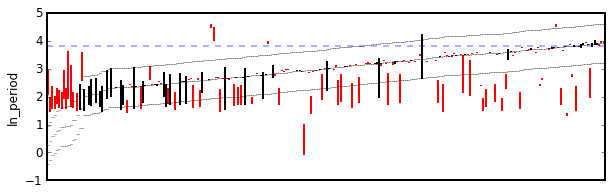

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import mpld3
from mpld3 import plugins
mpld3.enable_notebook()

inds = df.index[np.argsort(df.aigrain_p_mean)]
fig, ax = plt.subplots(1, 1, figsize=(10,3))
lines = []
labels = []
colors = []
ln2 = np.log(2)
di = 0.5
for i,ix in enumerate(inds):
    ymin, ymax = df.ix[ix, ['aigrain_p_min', 'aigrain_p_max']]
    ymean = (ymin + ymax)/2.
    ax.plot([i,i], [ymin, ymax], color='k', alpha=0.2)
    ax.plot([i-di, i+di], [ymean, ymean], color='k', lw=1, alpha=0.3)
    ax.plot([i-di, i+di], [ymean-ln2, ymean-ln2], color='k', lw=1, alpha=0.3)
    ax.plot([i-di, i+di], [ymean+ln2, ymean+ln2], color='k', lw=1, alpha=0.3)
#     tau, peq = df.ix[ix, ['TAU', 'PEQ']]
#     y_tau = np.log(tau*peq)
#     ax.plot([i-0.5, i+1.5], [y_tau, y_tau], color='k', lw=1)
    
    
    ylo, yhi = df.ix[ix, ['ln_period_16', 'ln_period_84']]
    if (yhi < ymin) or (ylo > ymax):
        color='r'
    else:
        color='k'
    lines.append(([i,ylo], [i,yhi]))
    colors.append(color)
    label = '{}: AMP={:.2e}'.format(ix, df.ix[ix, 'AMP'])
    labels.append(label)

collection = LineCollection(lines, colors=colors, linewidths=2)
ax.add_collection(collection)
ax.set_xlim((-0.5, i+0.5))
ax.set_xticks([]);
ax.set_ylabel('ln_period');
ax.plot([-0.5, i+0.5], [np.log(45), np.log(45)], ls='--', color='b', alpha=0.3);

tooltip = mpld3.plugins.PointLabelTooltip(collection, labels=labels)
plugins.connect(fig, tooltip)

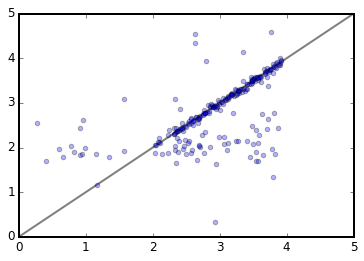

In [5]:
fig, ax = plt.subplots(1,1)
points = ax.scatter(df.aigrain_p_mean, df.ln_period_50, alpha=0.3)
ax.plot(range(6), range(6), 'k', lw=2, alpha=0.5, zorder=0)
ax.set_xlim((0,5))
ax.set_ylim((0,5))
tooltip = mpld3.plugins.PointLabelTooltip(points, labels=[i for i in df.index])
plugins.connect(fig, tooltip)

In [28]:
i = 279
print(np.log(truth.ix[i, ['P_MIN','P_MAX']]))
print(df.ix[i, ['ln_period_16', 'ln_period_84']])

P_MIN    3.905804
P_MAX    3.905804
Name: 279, dtype: float64
ln_period_16    2.601855
ln_period_84    2.651217
Name: 279, dtype: float64


In [30]:
np.exp(3.906)

49.699754825406366

In [31]:
from gprot.lc import qtr_times
qtr_times

,tstart,tstop
q,,
1,131.511880,164.983257
2,169.518900,258.466998
3,260.223736,349.494411
4,352.376612,442.202053
5,443.489554,538.161241
6,539.449771,629.295934
7,630.174122,719.547036
8,735.362357,802.343677
9,808.515159,905.926044
